# General Experiments

### Scope
In this notebook, we use one of the possible configurations of our LightGCNPlus model to experiment with different hyperparameters and configurations.

In [4]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from train import train_model
from models import LightGCNPlus
from config import DEVICE
from train import train_model
from postprocess import report_training_results
from itertools import product

In [5]:
from load import load_train_data
train_df = load_train_data()

In [6]:
from preprocess import preprocess

# A_tilde, \
# train_users, train_items, train_ratings, \
# val_users, val_items, val_ratings \
# = preprocess(train_df)

In [7]:
# # save validation set to train ensemble
# train_df = pd.DataFrame({
#     "train_users": train_users.cpu().numpy(),
#     "train_items": train_items.cpu().numpy(),
#     "train_ratings": train_ratings.cpu().numpy()
# })
# train_df.to_csv("../data/model_state/train_df.csv", index=False)

# val_df = pd.DataFrame({
#     "val_users": val_users.cpu().numpy(),
#     "val_items": val_items.cpu().numpy(),
#     "val_ratings": val_ratings.cpu().numpy()
# })
# val_df.to_csv("../data/model_state/val_df.csv", index=False)

In [8]:
# # save A_tilde to file in same repo as val_df
# np.save("../data/model_state/A_tilde.npy", A_tilde.cpu().numpy())

In [9]:
A_tilde = torch.tensor(np.load("../data/model_state/A_tilde.npy")).to(DEVICE)

In [10]:
train_df = pd.read_csv("../data/model_state/train_df.csv")
train_users, train_items, train_ratings = torch.tensor(train_df["train_users"].values, dtype=torch.long).to(DEVICE), \
    torch.tensor(train_df["train_items"].values, dtype=torch.long).to(DEVICE), \
    torch.tensor(train_df["train_ratings"].values, dtype=torch.float32).to(DEVICE)

val_df = pd.read_csv("../data/model_state/val_df.csv")
val_users, val_items, val_ratings = torch.tensor(val_df["val_users"].values, dtype=torch.long).to(DEVICE), \
    torch.tensor(val_df["val_items"].values, dtype=torch.long).to(DEVICE), \
    torch.tensor(val_df["val_ratings"].values, dtype=torch.float32).to(DEVICE)

In [11]:
# Model and optimizer hyperparameters
INIT_EMBS_STD=0.075
LR=0.1
WEIGHT_DECAY=0.00005
DROPOUT=0.5
ACT_FN = nn.GELU()

# Train loop hyperparameters
EPOCHS = 3000
STOP_THRESHOLD=1e-09

# To be searched (example values)
K=32
L=8
C = (9,)

# TODO: try a much bigger K

In [12]:
# # Grid
# ks = [28]  # different Ks work with different projections
# layers = [5]  # tested 3 already
# projections = [(6,)]

# num_combinations = len(ks) * len(layers) * len(projections)
# print(f"Searching over {num_combinations} combinations.")

In [13]:
# TODO: write load from checkpoint function

In [14]:
# # Tuning LightGCNPlus
# results = {
#     "min_val_losses": [],
#     "params": []
# }
# for K in ks:
#     for L in layers:
#         for C in projections:
#             model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
#             optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#             loss_fn = nn.MSELoss()
#             print(f"K={K}, L={L}, C={C}")
#             train_rmse, val_rmse = train_model(model, optimizer, loss_fn, train_users, train_items, train_ratings, val_users, val_items, val_ratings, EPOCHS, STOP_THRESHOLD, save_best_model=True, verbosity=1)
#             report_training_results(train_rmse, val_rmse)
            
#             results["min_val_losses"].append(min(val_rmse))
#             results["params"].append((K, L, C))

In [15]:
# TODO: cannot continue training from checkpoint, because best_val = inf when resuming

# model = load_best_val_model(model_class, ID)
model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()
train_rmse, val_rmse = train_model(model, optimizer, loss_fn, train_users, train_items, train_ratings, val_users, val_items, val_ratings, EPOCHS, STOP_THRESHOLD, save_best_model=True, verbosity=1)
report_training_results(train_rmse, val_rmse)

KeyboardInterrupt: 

In [ ]:
# To be searched (example values)
K=32
L=9
C = (10,1)
EPOCHS = 5000

# model = load_best_val_model(model_class, ID)
model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()
train_rmse, val_rmse = train_model(model, optimizer, loss_fn, train_users, train_items, train_ratings, val_users, val_items, val_ratings, EPOCHS, STOP_THRESHOLD, save_best_model=True, verbosity=1)
report_training_results(train_rmse, val_rmse)

Epoch 1 - Best Val: 3.6521 at 1 - mv-avg: - Train: 3.6413 - Val: 17.0492
Epoch 2 - Best Val: 3.6521 at 1 - mv-avg: - Train: 18.7293 - Val: 45.1734
Epoch 3 - Best Val: 3.6521 at 1 - mv-avg: - Train: 48.3919 - Val: 10.3538
Epoch 4 - Best Val: 3.6521 at 1 - mv-avg: - Train: 10.8675 - Val: 4.0762
Epoch 5 - Best Val: 2.0280 at 6 - mv-avg: - Train: 4.3298 - Val: 2.0280
Epoch 6 - Best Val: 2.0280 at 6 - mv-avg: - Train: 5.5116 - Val: 2.2764
Epoch 7 - Best Val: 2.0280 at 6 - mv-avg: - Train: 5.8922 - Val: 6.2832
Epoch 8 - Best Val: 2.0280 at 6 - mv-avg: - Train: 7.0496 - Val: 3.6803
Epoch 9 - Best Val: 2.0280 at 6 - mv-avg: - Train: 5.2377 - Val: 6.5256
Epoch 10 - Best Val: 2.0280 at 6 - mv-avg: - Train: 7.2243 - Val: 2.3129
Epoch 11 - Best Val: 2.0280 at 6 - mv-avg: - Train: 3.1017 - Val: 3.5681
Epoch 12 - Best Val: 2.0280 at 6 - mv-avg: - Train: 5.0643 - Val: 2.2840
Epoch 13 - Best Val: 2.0280 at 6 - mv-avg: - Train: 2.9528 - Val: 3.4531
Epoch 14 - Best Val: 2.0280 at 6 - mv-avg: - Train: 3.

KeyboardInterrupt: 

In [16]:
# To be searched (example values)
K=28
L=5
C = (6,1)
EPOCHS = 4000

# model = load_best_val_model(model_class, ID)
model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()
train_rmse, val_rmse = train_model(model, optimizer, loss_fn, train_users, train_items, train_ratings, val_users, val_items, val_ratings, EPOCHS, STOP_THRESHOLD, save_best_model=True, verbosity=1)

Epoch 1 - Best Val: 3.4206 at 1 - mv-avg: - Train: 3.4109 - Val: 14.1434
Epoch 2 - Best Val: 3.4206 at 1 - mv-avg: - Train: 15.6830 - Val: 6.0910
Epoch 3 - Best Val: 3.2121 at 4 - mv-avg: - Train: 6.7188 - Val: 3.2121
Epoch 4 - Best Val: 3.2121 at 4 - mv-avg: - Train: 3.2058 - Val: 4.4696
Epoch 5 - Best Val: 2.9726 at 6 - mv-avg: - Train: 4.8988 - Val: 2.9726
Epoch 6 - Best Val: 2.4259 at 7 - mv-avg: - Train: 3.0280 - Val: 2.4259
Epoch 7 - Best Val: 1.4386 at 8 - mv-avg: - Train: 2.7360 - Val: 1.4386
Epoch 8 - Best Val: 1.4386 at 8 - mv-avg: - Train: 3.7963 - Val: 2.4075
Epoch 9 - Best Val: 1.4386 at 8 - mv-avg: - Train: 3.1984 - Val: 3.2561
Epoch 10 - Best Val: 1.4386 at 8 - mv-avg: - Train: 3.3779 - Val: 3.5602
Epoch 11 - Best Val: 1.4386 at 8 - mv-avg: - Train: 3.5693 - Val: 3.5638
Epoch 12 - Best Val: 1.4386 at 8 - mv-avg: - Train: 3.5632 - Val: 3.3594
Epoch 13 - Best Val: 1.4386 at 8 - mv-avg: - Train: 3.4034 - Val: 2.8660
Epoch 14 - Best Val: 1.4386 at 8 - mv-avg: - Train: 3.1320

In [ ]:
# save train_rmse, val_rmse as csv in same folder as A_tilde
results = pd.DataFrame({
    "train_rmse": train_rmse,
    "val_rmse": val_rmse
})
results.to_csv("../data/model_state/results.csv", index=False)

In [ ]:
# read results from csv
import pandas as pd
results = pd.read_csv("../data/model_state/results.csv")
train_rmse, val_rmse = results["train_rmse"].values, results["val_rmse"].values

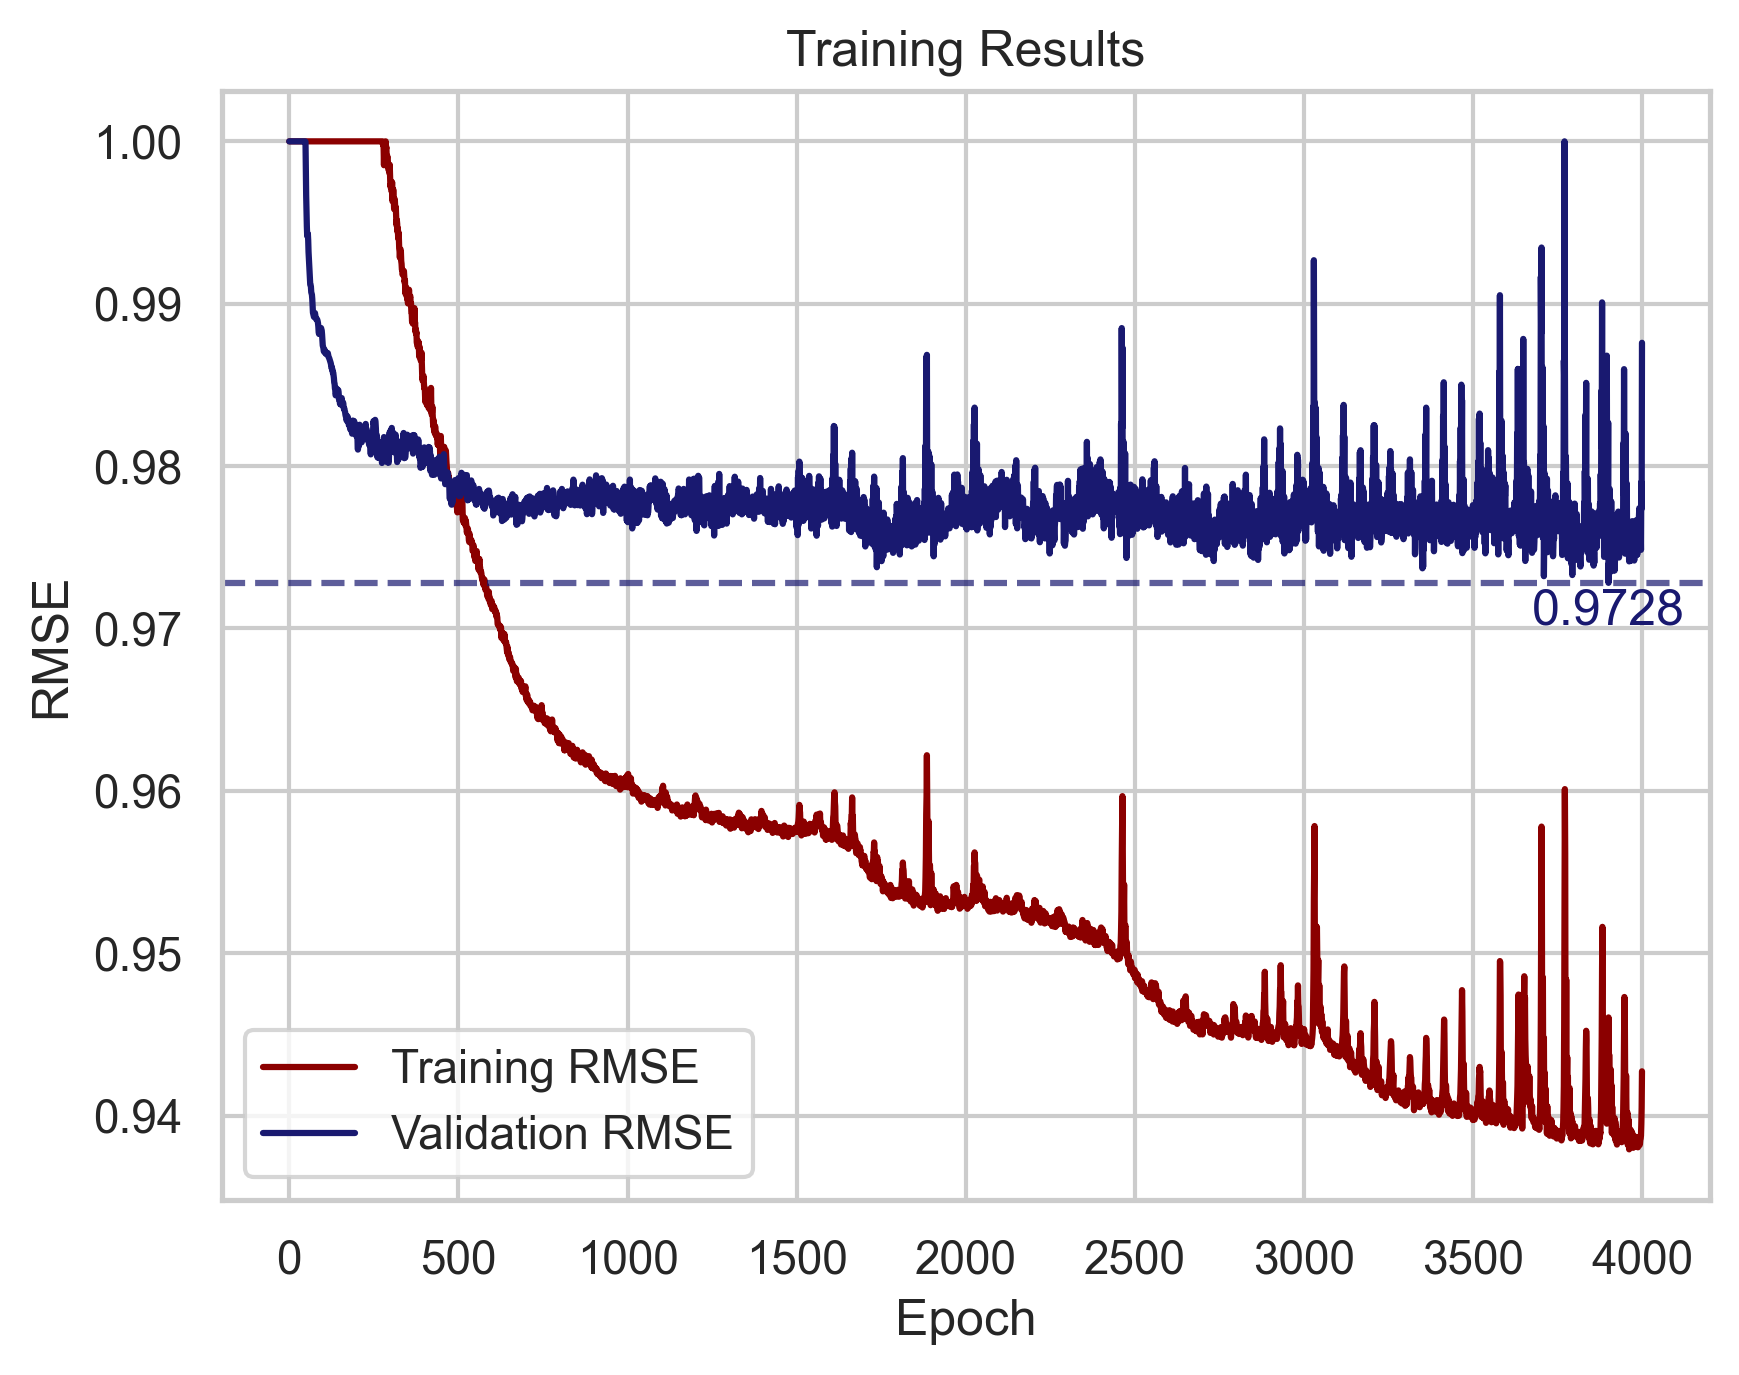

In [ ]:
from postprocess import report_training_results
report_training_results(train_rmse, val_rmse)

In [ ]:
# Report top k best hyperparameter combos
TOP_K = 10
best_ids = np.argsort(results["min_val_losses"])[:TOP_K]

for i in best_ids:
    print(f"Best hyperparameters: {results['params'][i]}")
    print(f"Best val loss: {results['min_val_losses'][i]}")

min: 0.04022169
max: 5.699665
mean: 3.8560307


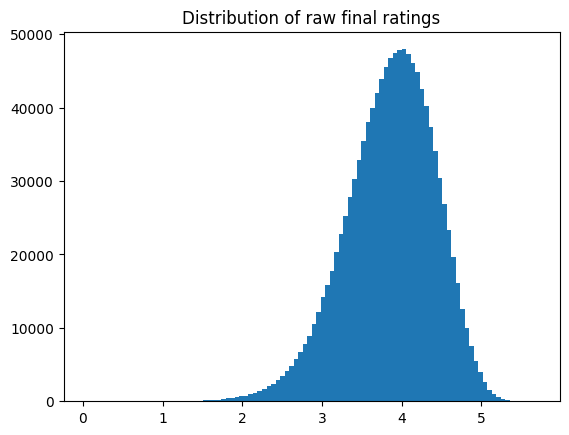

min: 1.0
max: 5.0
mean: 3.8553733392107703
count_over_5: 0
count_under_1: 0

min: 1.0
max: 5.0
mean: 3.8553733392107703


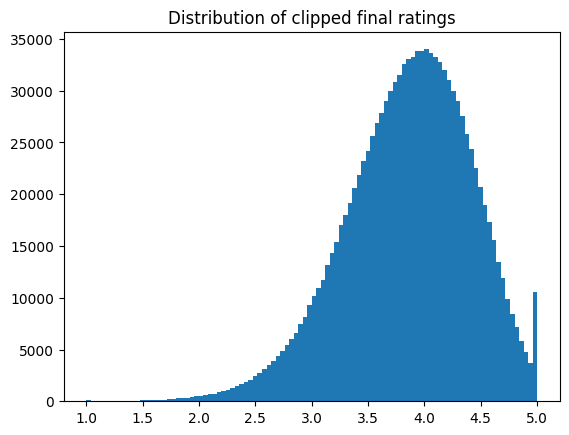

In [ ]:
from postprocess import load_submission_users_items, report_submission_results, create_submission_matrix, report_clip_data, to_submission_format, load_means_stds, load_best_val_model

model_class = LightGCNPlus
ID = str(28) + "_" + str(5) + "_" + str((6,))

sub_users, sub_items = load_submission_users_items()
model = load_best_val_model(model_class, ID)

# Get predictions from model for submission users and items
raw_pred_ratings = model.get_ratings(sub_users, sub_items).detach().cpu().numpy()
raw_submission_matrix = create_submission_matrix(raw_pred_ratings, sub_users, sub_items)
pred_ratings = raw_submission_matrix[sub_users, sub_items]
pred_ratings = np.clip(pred_ratings, 1, 5)

# Report results
report_submission_results(raw_pred_ratings, "raw")
report_clip_data(pred_ratings)
report_submission_results(pred_ratings, "clipped")

# Generate submission file
submission = to_submission_format(sub_users, sub_items, pred_ratings)
submission.to_csv('../data/submission_data/submission.csv', index=False)